
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Автоэнкодеры


# Часть 1. Vanilla Autoencoder 

## 1.1. Подготовка данных


In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from matplotlib import rcParams
from IPython.display import clear_output
rcParams['figure.figsize'] = (15,4)

from tqdm import tqdm_notebook


%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()


Разобьем выборку картинок на train и val, выведем несколько картинок в output, чтобы посмотреть, как они выглядят, и приведем картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(torch.permute(torch.tensor(train_photos, dtype=torch.float32), (0, 3, 1, 2)),batch_size=32)
val_loader = torch.utils.data.DataLoader(torch.permute(torch.tensor(val_photos, dtype=torch.float32), (0, 3, 1, 2)), batch_size=32)

Посмотрим на несколько изображений

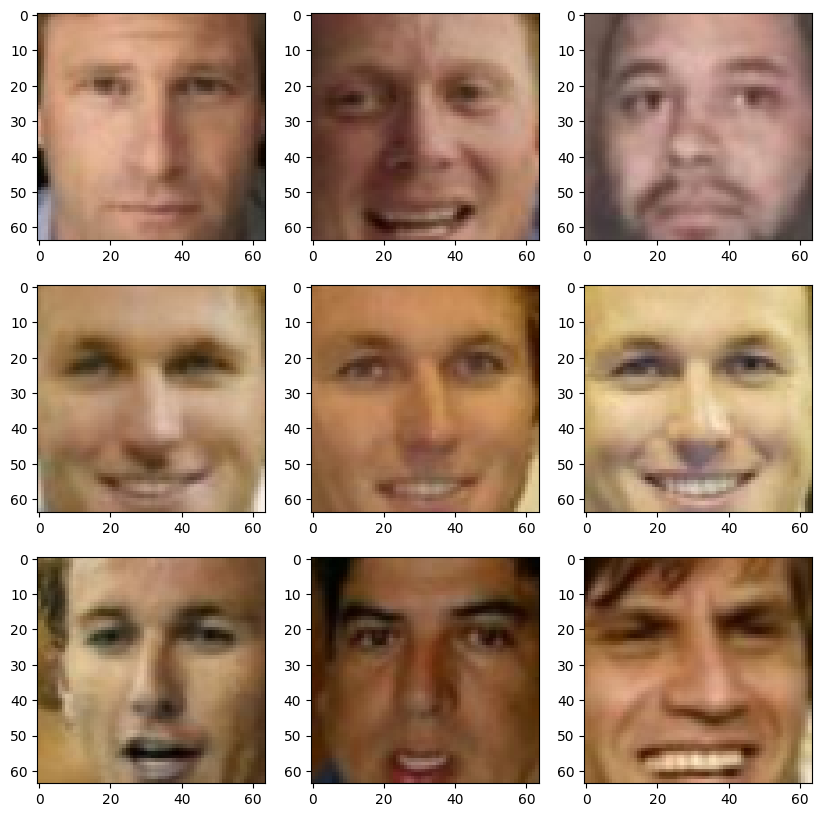

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img = train_photos[i]
    ax.imshow(img)
    ax.set_aspect('auto')

## 1.2. Архитектура модели
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">



In [ ]:
dim_code = [32, 64, 128, 256]
 # выберите размер латентного вектора

Реализуем autoencoder.

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self, dim_code):
        
      super().__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(3, 32, 3, padding = 1),
          nn.BatchNorm2d(32),
          nn.LeakyReLU(),

          nn.Conv2d(32, 32, 3, padding = 1),
          nn.BatchNorm2d(32),
          nn.LeakyReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2), # 64->32

          nn.Conv2d(32, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),

          nn.Conv2d(64, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),
          nn.MaxPool2d(kernel_size = 2, stride = 2), # 32 -> 16

          nn.Conv2d(64, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),

          nn.Conv2d(64, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),
          nn.MaxPool2d(kernel_size = 2, stride = 2), # 16 -> 8

          nn.Flatten(),
          nn.Linear(8*8*64, dim_code))

      self.decoder = nn.Sequential(
          nn.Linear(dim_code, 8 * 8* 64),
          nn.Unflatten(1, (64, 8, 8)),
          nn.ConvTranspose2d(64, 64, stride = (2,2), kernel_size = 3, padding = 0),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),
          nn.ConvTranspose2d(64, 32, stride = (2,2), kernel_size = 3, padding = 1),
          nn.BatchNorm2d(32),
          nn.LeakyReLU(0.01),
          nn.ConvTranspose2d(32, 3, stride = (2,2), kernel_size = 3, padding = 2, output_padding = 1),
          nn.Sigmoid()

      )

    def forward(self, x):
      latent = self.encoder(x)
      reconstructed = self.decoder(latent)
      return reconstructed, latent

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = nn.BCELoss()

autoencoder = Autoencoder(32).to(device)

Проверим размаерности на входе и выходе

In [ ]:
# Загрузка одного пакета данных
data_ = next(iter(train_loader))
print("Размерность входных данных:", data_.shape)

# Прямой проход через энкодер
latent = autoencoder.encoder(data.to(device))
print("Размерность выхода после энкодера:", latent.shape)

# Прямой проход через декодер
reconstructed = autoencoder.decoder(latent)
print("Размерность выхода после декодера:", reconstructed.shape)

Размерность входных данных: torch.Size([32, 3, 64, 64])
Размерность выхода после энкодера: torch.Size([32, 32])
Размерность выхода после декодера: torch.Size([32, 3, 64, 64])


## 1.3 Обучение

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def plot_training(train_loss, val_loss, d):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.title(f"Размер латентного вектора {d}")
    plt.xlabel("epoch")
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="valid_loss")
    plt.xticks(np.arange(0, len(train_loss),1.0))
    plt.legend()
    plt.show()


In [ ]:
def train (model, loss_fn, opt, data_train, data_val, n_epochs, d):
  train_loss = []
  val_loss = []

  for epoch in range(n_epochs):
      model.train()
      train_losses_per_epoch = []
      for batch in data_train:
          opt.zero_grad()
          reconstructed,latent_code = autoencoder(batch.to(device))
          loss = loss_fn(reconstructed, batch.to(device))
          loss.backward()
          opt.step()
          train_losses_per_epoch.append(loss.item())

      train_loss.append(np.mean(train_losses_per_epoch))
      model.eval()
      val_losses_per_epoch = []
      with torch.no_grad():
          for batch in data_val:
            reconstructed,latent_code = autoencoder(batch.to(device))
            loss = loss_fn(reconstructed, batch.to(device))
            val_losses_per_epoch.append(loss.item())
      val_loss.append(np.mean(val_losses_per_epoch))

      some_samples = next(iter(data_val))
      with torch.no_grad():
        reconstructed,latent_code = autoencoder(some_samples.cuda())
        result = np.rollaxis(reconstructed.detach().cpu().numpy(), 1, 4)
        some_samples = np.rollaxis(some_samples.numpy(), 1, 4)
      clear_output(wait=True)
      for k in range(6):
          plt.subplot(2, 6, k+1)
          plt.imshow(some_samples[k])
          plt.title('Real')
          plt.axis('off')

          plt.subplot(2, 6, k+7)
          plt.imshow(result[k])
          plt.title('Output')
          plt.axis('off')

      plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, val_loss[epoch]))
      plot_training(train_loss, val_loss, d)
      plt.show()
  return train_loss, val_loss


Создадим таблицу, в которую будем заносить результаты обучения модели

In [ ]:
training_results = pd.DataFrame(columns=['dim_code', 'loss'])

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

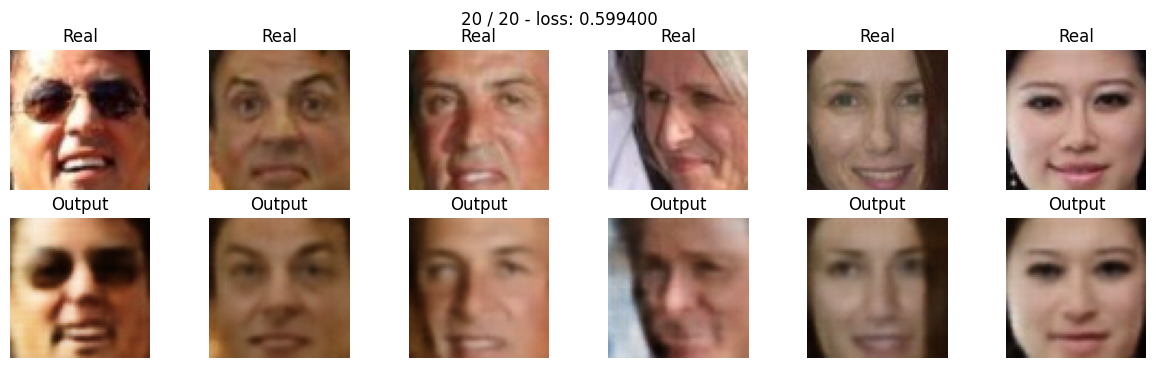

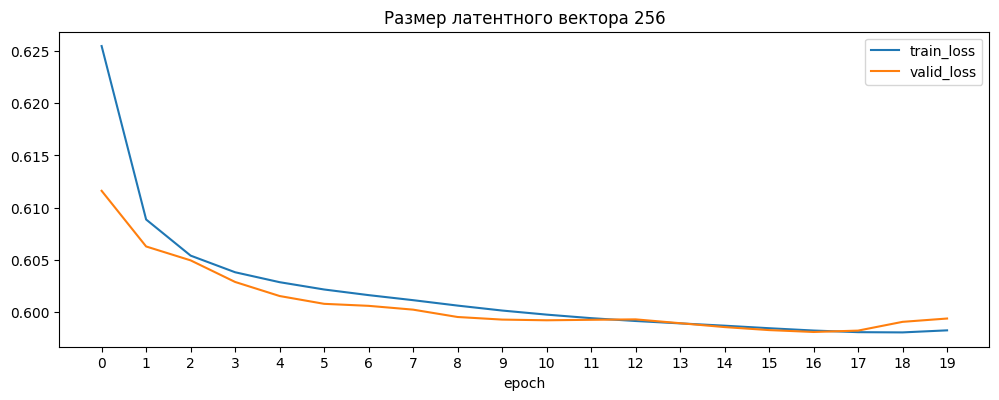

In [ ]:
for d in dim_code:
  autoencoder = Autoencoder(d).to(device)
  optimizer = optim.Adam(autoencoder.parameters()) #<Ваш любимый оптимизатор>
  train_loss, val_loss = train(autoencoder, criterion, optimizer, train_loader, val_loader, 20, d)
  training_results.loc[ len(training_results.index )] = [d, val_loss[-1]]

In [ ]:
training_results = training_results.sort_values(by = ['loss'], ascending = False).reset_index()


In [ ]:
training_results= training_results[['dim_code', 'loss']]

In [ ]:
training_results

,dim_code,loss
0,32.0,0.605357
1,64.0,0.601763
2,256.0,0.599400
3,128.0,0.598934


In [ ]:
  autoencoder.eval()
  with torch.no_grad():
      for batch in val_loader:
        reconstructed,latent_code = autoencoder(batch.to(device))
        result = np.rollaxis(reconstructed.detach().cpu().numpy(), 1, 4)
        ground_truth = np.rollaxis(batch.numpy(), 1, 4)
        break

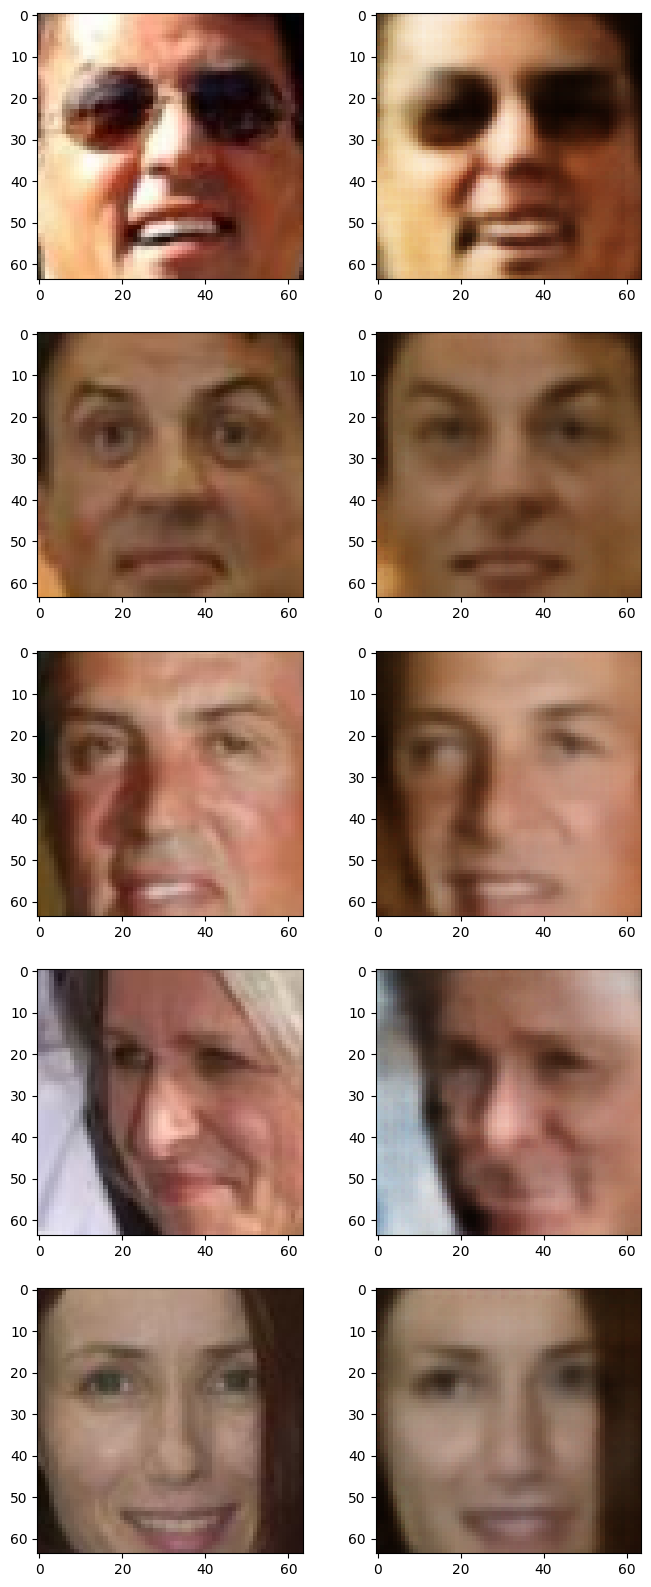

In [ ]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

Not bad, right?

## 1.4. Sampling

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

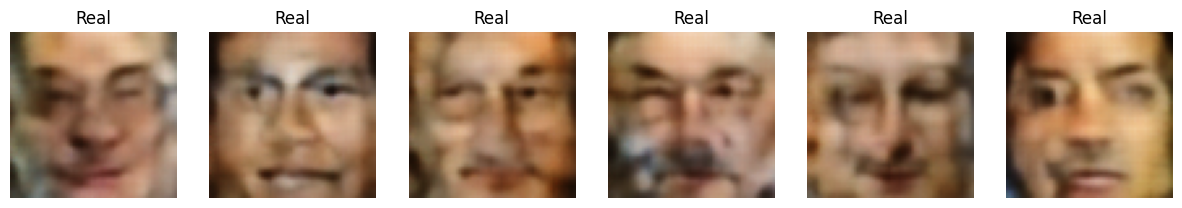

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, 256)
some_samples = next(iter(val_loader))
autoencoder.eval()
with torch.no_grad():
  _,latent_code = autoencoder(some_samples.to(device))
  mean = torch.mean(latent_code, dim=0)
  std = torch.std(latent_code, dim=0)
  tensored = torch.FloatTensor(z)
  z = mean + std * tensored.to(device)
  output = autoencoder.decoder(torch.Tensor(z).cuda())
  result = np.rollaxis(output.detach().cpu().numpy(), 1, 4)
for k in range(6):
    plt.subplot(1, 6, k+1)
    plt.imshow(result[k])
    plt.title('Real')
    plt.axis('off')


Что-то похожее на человека)

## 1.5 Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13143 entries, 0 to 13142
Data columns (total 73 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Male                        13143 non-null  object
 1   Asian                       13143 non-null  object
 2   White                       13143 non-null  object
 3   Black                       13143 non-null  object
 4   Baby                        13143 non-null  object
 5   Child                       13143 non-null  object
 6   Youth                       13143 non-null  object
 7   Middle Aged                 13143 non-null  object
 8   Senior                      13143 non-null  object
 9   Black Hair                  13143 non-null  object
 10  Blond Hair                  13143 non-null  object
 11  Brown Hair                  13143 non-null  object
 12  Bald                        13143 non-null  object
 13  No Eyewear                  13143 non-null  ob

In [ ]:
def get_smiling_people(data):
    smile = data[data['Smiling'] > 1].index
    smily = np.random.choice(smile,20)
    return smily
def get_frowning_people(data):
    frown = data[data['Frowning'] > 1].index
    frown = np.random.choice(frown,20)
    return frown
def plot_people(samples, data):
    plt.figure(figsize=(16, 5))
    for i, gt in enumerate(data[samples]):
        plt.subplot(4, 5, i+1)
        plt.imshow(gt)
        plt.axis('off')

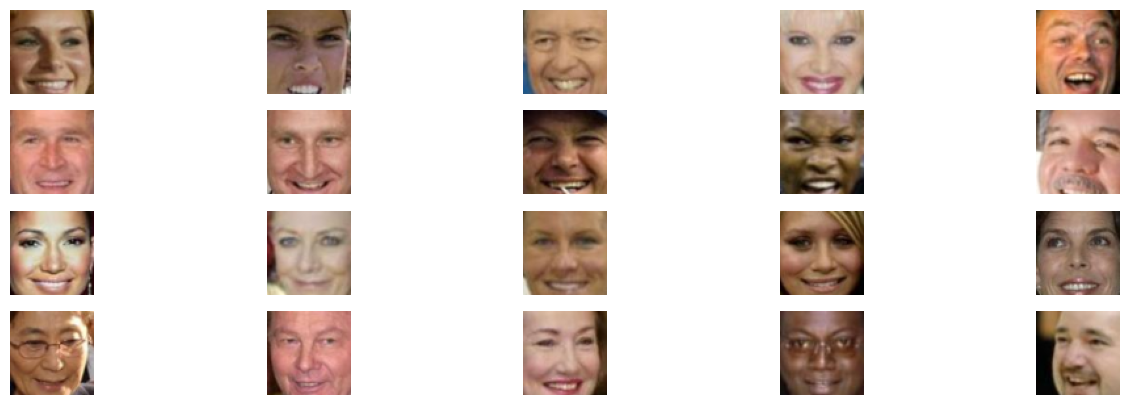

In [ ]:
smile = get_smiling_people(attrs)

plot_people(smile, data)

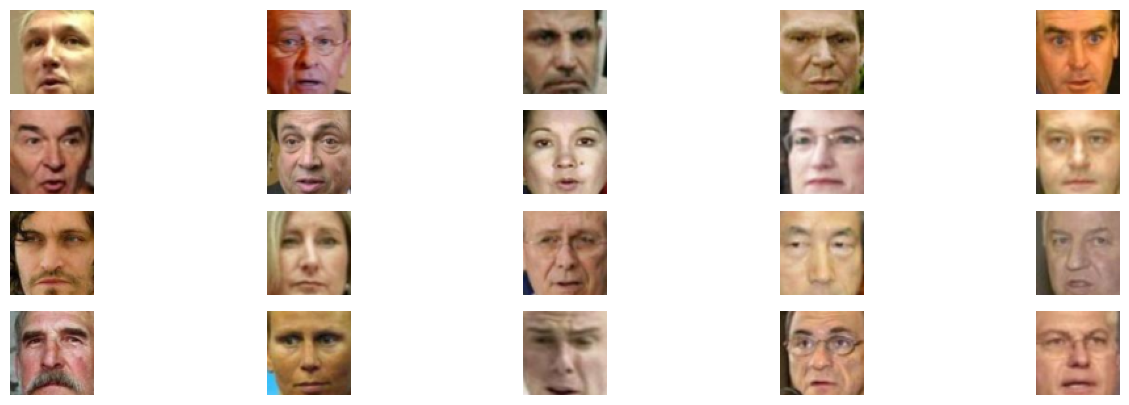

In [ ]:
frown = get_frowning_people(attrs)

plot_people(frown, data)

In [ ]:
smiling_data = torch.permute(torch.tensor(data[smile], dtype=torch.float32), (0, 3, 1, 2))
frowning_data = torch.permute(torch.tensor(data[frown], dtype=torch.float32), (0, 3, 1, 2))

In [ ]:
autoencoder.eval()
with torch.no_grad():
  _,latent_smile = autoencoder(smiling_data.to(device))
  _,latent_frown = autoencoder(frowning_data.to(device))
# получаем "вектор улыбки"
smile_vector = latent_smile.mean(dim = 0) - latent_frown.mean(dim=0)

In [ ]:
# создаем функцию для удобного заставляния людей улыбаться
def make_smile(autoencoder, data):
  autoencoder.eval()
  with torch.no_grad():
    latent_space = autoencoder.encoder(data.cuda())
    latent_space += smile_vector.cuda()
    reconstructed = autoencoder.decoder(latent_space)
    reconstructed = np.rollaxis(reconstructed.detach().cpu().numpy(), 1, 4)
  return reconstructed

In [ ]:
generated_data = make_smile(autoencoder, frowning_data.cuda())

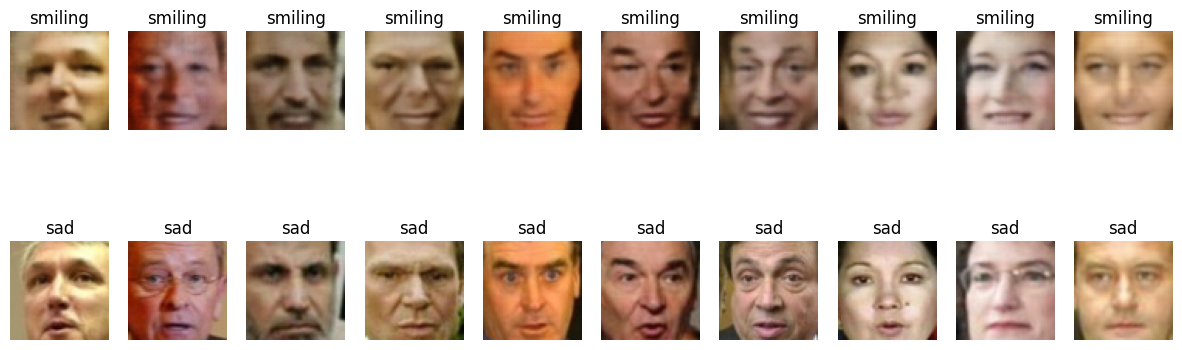

In [ ]:
plt.figure(figsize=(15, 5))
for i, (gt, res) in enumerate(zip(generated_data[:10], data[frown][:10])):
    plt.subplot(2, 10, i + 1)
    plt.imshow(gt)
    plt.axis('off')
    plt.title('smiling')

    plt.subplot(2, 10, i + 11)

    plt.imshow(res)
    plt.axis('off')
    plt.title('sad')
plt.show()

# Часть 2: Variational Autoencoder

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4583285.98it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 131490.58it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1269334.00it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4097769.15it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение

Реализуем VAE. 

In [ ]:
dim_features = 7
class VAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(10),
            nn.ReLU(),

            nn.Conv2d(10, 20, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) ,#batch_size x 20 x 14 x 14

            nn.Conv2d(20, 40, kernel_size= 3, padding = 1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # batch_size x 40 x 7 x 7

            nn.Flatten(),

            nn.Linear(40 * 7 * 7, dim_features * 2)
            )
        self.decoder = nn.Sequential(
            nn.Linear(dim_features, 40 * 7 * 7),
            nn.Unflatten(1, (40, 7, 7)), # 7
            nn.Upsample(scale_factor=2), # 7 -> 14
            nn.BatchNorm2d(40),
            nn.ReLU(),

            nn.ConvTranspose2d(40, 20, kernel_size = 3, stride = 1, padding = 1), # 14 -> 14
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.ConvTranspose2d(20, 1, kernel_size= 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )


    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logvar>
        x = self.encoder(x).view(-1, 2, dim_features)
        #print(x.shape)
        mu = x[:, 0, :]
        logvar = x[:, 1, :]
        #print('mu', mu.shape)
        #print('logvar', logvar.shape)
#print(self.encoder(x).shape)
        return mu, logvar

    def gaussian_sampler(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + (eps * std)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logvar = self.encode(x)
        z = self.gaussian_sampler(mu, logvar)

        # decoding
        reconstruction = self.decode(z)
        return mu, logvar, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    #print(mu.shape, logsigma.shape)
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())

    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
def train_vae(autoencoder, optimizer,n_epochs, criterion):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        autoencoder.train()
        train_losses_per_epoch = []
        for batch, _ in train_loader:
            optimizer.zero_grad()
            mu, logsigma, reconstruction,  = autoencoder(batch.to(device))
            reconstruction = reconstruction.view(-1,1, 28, 28)
            loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        train_losses.append(np.mean(train_losses_per_epoch))

    print('Обучение завершено')
    return train_losses#, val_loses

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
train = train_vae(autoencoder, optimizer,10, criterion)

Обучение завершено


In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch,_ in test_loader:
        mu, logsigma,reconstruction = autoencoder(batch.to(device))
        #reconstruction = reconstruction.view(-1, 64, 64, 3)
        #result = reconstruction.cpu().detach().numpy()
        result = np.rollaxis(reconstruction.detach().cpu().numpy(), 1, 4)
        ground_truth = np.rollaxis(batch.numpy(), 1, 4)
        break

(28, 28, 1)
(32, 28, 28, 1)


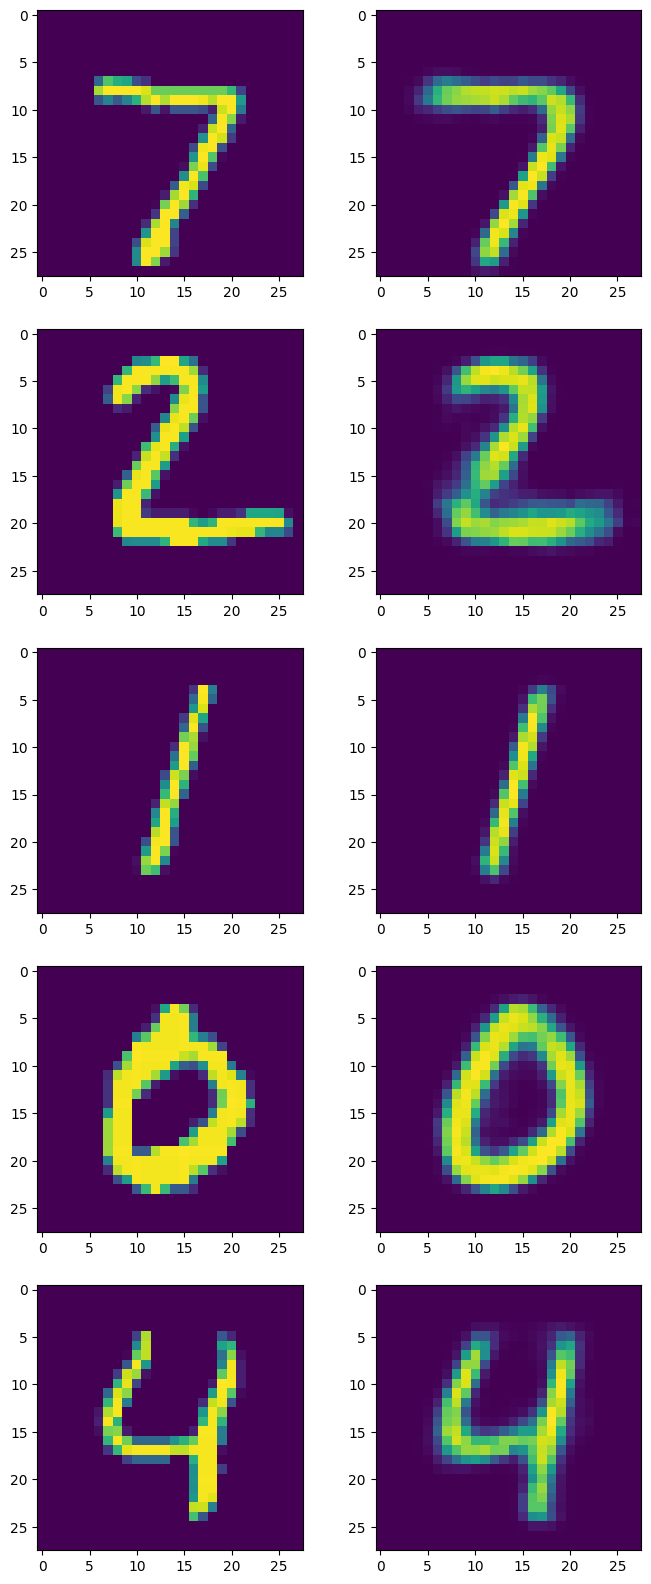

In [ ]:
print(result[0].shape)
print(ground_truth.shape)
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(gt)
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(res)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

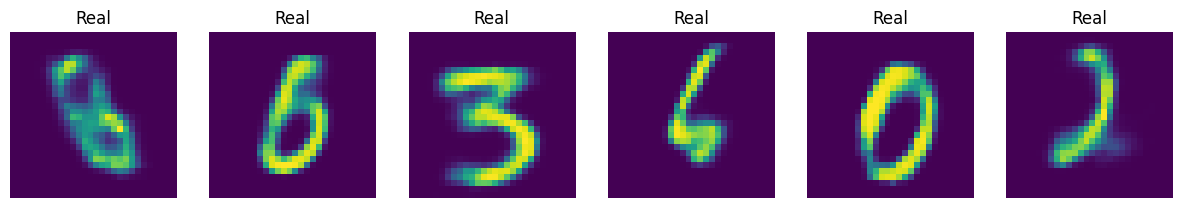

In [ ]:

z = np.array([np.random.normal(0, 1, 7) for i in range(10)])
some_samples,_ = next(iter(test_loader))
autoencoder.eval()
with torch.no_grad():
    mu, logsigma, reconstruction,  = autoencoder(some_samples.to(device))
    mean = torch.mean(mu, dim=0)
    std = torch.std(mu, dim=0)
    tensored = torch.FloatTensor(z)
    z = mean + std * tensored.to(device)
    output = autoencoder.decode(torch.Tensor(z).cuda())
    result = np.rollaxis(output.detach().cpu().numpy(), 1, 4)
for k in range(6):
    plt.subplot(1, 6, k+1)
    plt.imshow(result[k])
    plt.title('Real')
    plt.axis('off')

## 2.2. Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
autoencoder.eval()
latent = []
with torch.no_grad():
    for batch, _ in test_loader:
        mu, logvar = autoencoder.encode(batch.cuda())
        z = autoencoder.gaussian_sampler(mu, logvar)
        latent.append(z.cpu().detach().numpy())
    latent = np.vstack(latent)
tsne = TSNE()
latent_transform = tsne.fit_transform(latent)


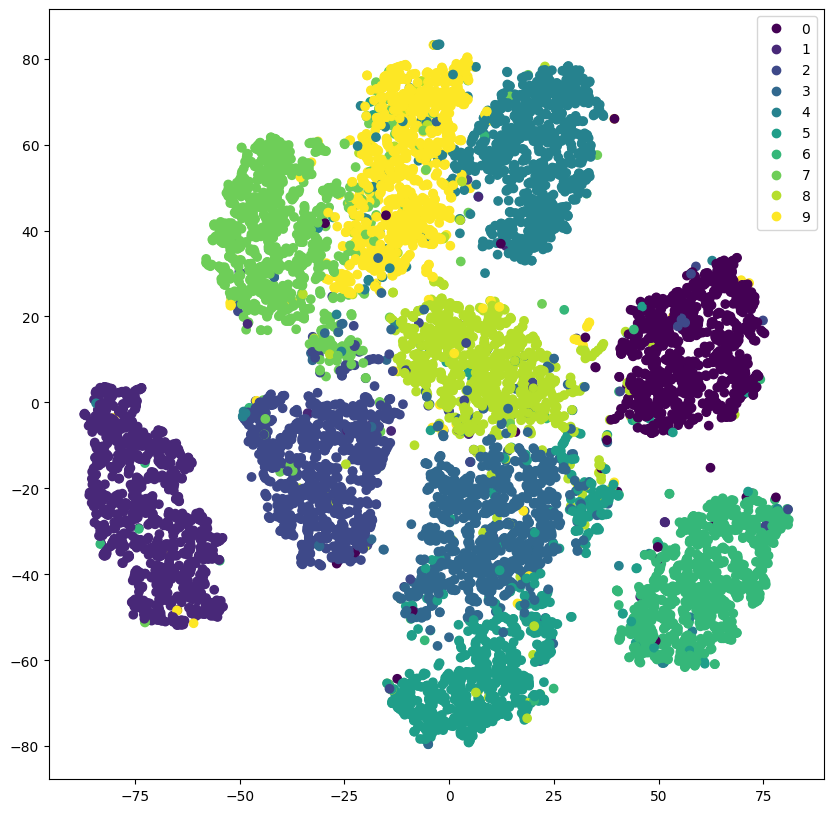

In [ ]:
plt.figure(figsize = (10,10))
scatter = plt.scatter(latent_transform[:, 0], latent_transform[:, 1], c = test_dataset.targets)
plt.legend(*scatter. legend_elements ())
plt.show()

__Congrats v2.0!__

## 2.3. Conditional VAE


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
dim_features = 7
class CVAE(nn.Module):
    def __init__(self, num_classes):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()
        self.num_classes = num_classes
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + self.num_classes, 10, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(10),
            nn.ReLU(),

            nn.Conv2d(10, 20, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) ,#batch_size x 20 x 14 x 14

            nn.Conv2d(20, 40, kernel_size= 3, padding = 1),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # batch_size x 40 x 7 x 7

            nn.Flatten(),

            nn.Linear((40 * 7 * 7), dim_features * 2)
            )
        self.decoder = nn.Sequential(
            nn.Linear(dim_features+self.num_classes, 40 * 7 * 7),
            nn.Unflatten(1, (40, 7, 7)), # 7
            nn.Upsample(scale_factor=2), # 7 -> 14
            nn.BatchNorm2d(40),
            nn.ReLU(),

            nn.ConvTranspose2d(40, 20, kernel_size = 3, stride = 1, padding = 1), # 14 -> 14
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.ConvTranspose2d(20, 1, kernel_size= 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )

    def encode(self, x, labels):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logvar>
        label = F.one_hot(labels, num_classes=self.num_classes).float()
        label = label.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, label], dim = 1)
        x = self.encoder(x).view(-1, 2, dim_features)
        mu = x[:, 0, :]
        logvar = x[:, 1, :]

        return mu, logvar

    def gaussian_sampler(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + (eps * std)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu


    def decode(self, z, labels):
        labels = F.one_hot(labels, num_classes=self.num_classes).float()
        reconstruction = self.decoder(torch.cat([z, labels], dim = 1))

        return reconstruction

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.gaussian_sampler(mu, logvar)


        reconstruction = self.decode(z, labels)
        return mu, logvar, reconstruction

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = loss_vae

autoencoder = CVAE(num_classes=10).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
n_epochs = 20
for epoch in range(n_epochs):
        autoencoder.train()
        train_losses_per_epoch = []
        for batch, labels in train_loader:
            optimizer.zero_grad()
            mu, logvar, reconstruction  = autoencoder(batch.to(device), labels.to(device))
            reconstruction = reconstruction.view(-1,1, 28, 28)
            loss = criterion(batch.to(device).float(), mu, logvar, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
print('обучение завершено')

обучение завершено


### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
def get_num (num):
  autoencoder.eval()
  with torch.no_grad():
    latent_vector = np.array([np.random.normal(0, 1, dim_features) for i in range(1)])
    temp_generated  = autoencoder.decode(torch.Tensor(latent_vector).cuda(),
                                         torch.LongTensor([num]).cuda()).cpu().detach().squeeze()
  plt.imshow(temp_generated, cmap='gray')

Получим произвольную цифру

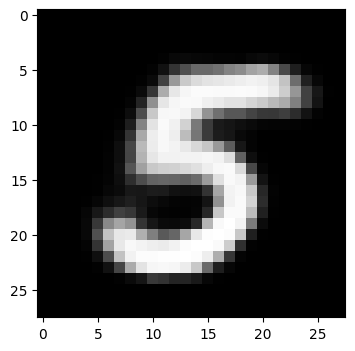

In [ ]:
get_num(5)

### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
autoencoder.eval()
latent = []
with torch.no_grad():
    for batch, labels in test_loader:
        mu, logvar = autoencoder.encode(batch.to(device), labels.to(device))
        z = autoencoder.gaussian_sampler(mu, logvar)
        latent.append(z.cpu().detach().numpy())
    latent = np.vstack(latent)
tsne = TSNE()
latent_transform = tsne.fit_transform(latent)


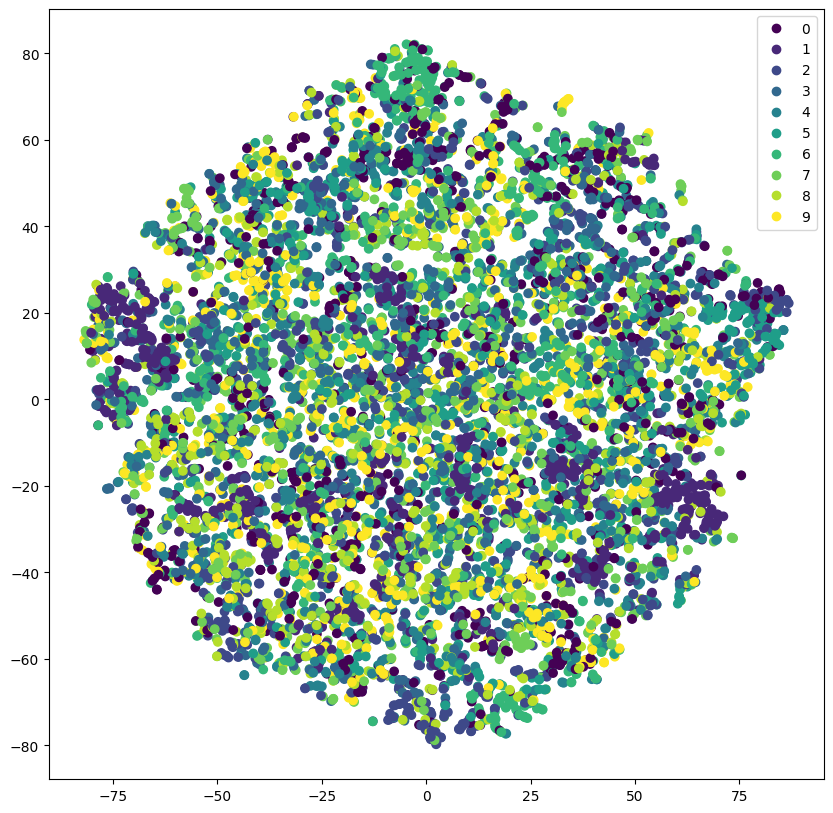

In [ ]:
plt.figure(figsize = (10,10))
scatter = plt.scatter(latent_transform[:, 0], latent_transform[:, 1], c = test_dataset.targets)
plt.legend(* scatter. legend_elements ())
plt.show()

Мы видим непонятную смесь из точек вместо явных кластеров, которые выделяла обычная модель VAE. Однако дело тут в том, что, вместо того, чтобы пытаться размещать все цифры в одном пространстве, модель использует отдельное латентное пространство для каждой цифры: